# EDA Notes

A first attempt at EDA for the CS109 final project. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
%matplotlib inline
import json

**Read In Data**

In [3]:
checkins = pd.read_csv('Data/checkin_summary.csv', header=None)
photos = pd.read_csv('Data/photos_summary.csv', header=None)
reviews = pd.read_csv('Data/review_small.csv', header=None)
biz = pd.read_csv('Data/small_businesses.csv')
tips = pd.read_csv('Data/tip_summary.csv', header=None)
users = pd.read_json(path_or_buf='Data/user_small.json', lines=True)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,10,12,14,20,63,64,74) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean Columns and Data

In [99]:
users['elite_count'] = users.iloc[:,1].apply(lambda x: len(x))
users['join_date'] = pd.to_datetime(users['yelping_since'])
users.head()

,average_stars,elite,review_count,user_id,yelping_since,elite_count,join_date
0,3.80,"[2014, 2016, 2013, 2011, 2012, 2015, 2010, 2017]",272,lsSiIjAKVl-QRxKjRErBeg,2010-07-13,8,2010-07-13
1,3.94,"[2014, 2017, 2011, 2012, 2015, 2009, 2013, 200...",2559,om5ZiponkpRqUNa3pVPiRg,2006-01-18,12,2006-01-18
2,4.72,[],277,-lGwMGHMC_XihFJNKCJNRg,2014-10-31,0,2014-10-31
3,3.76,"[2016, 2017]",436,D-ydMTPGWXTVm4_jjp0k9g,2013-04-01,2,2013-04-01
4,4.23,"[2017, 2016]",921,PcvbBOCOcs6_suRDH7TSTg,2012-08-16,2,2012-08-16


In [100]:
users.dtypes

average_stars           float64
elite                    object
review_count              int64
user_id                  object
yelping_since            object
elite_count               int64
join_date        datetime64[ns]
dtype: object

In [5]:
checkins.shape, photos.shape, reviews.shape, biz.shape, tips.shape, users.shape

((49414, 2), (26384, 2), (2927859, 4), (38668, 93), (558979, 3), (1183362, 6))

In [6]:
checkins.columns = ['business_id', 'num_checkins'] 
checkins.head()

,business_id,num_checkins
0,--6MefnULPED_I942VcFNA,122
1,--9e1ONYQuAa-CB_Rrw7Tw,2469
2,--DaPTJW3-tB1vP-PfdTEg,88
3,--FBCX-N37CMYDfs790Bnw,477
4,--GM_ORV2cYS-h38DSaCLw,13


In [7]:
photos.columns = ['business_id', 'num_photos'] 
photos.head()

,business_id,num_photos
0,--6MefnULPED_I942VcFNA,1
1,--9e1ONYQuAa-CB_Rrw7Tw,127
2,--DaPTJW3-tB1vP-PfdTEg,1
3,--FBCX-N37CMYDfs790Bnw,4
4,--KCl2FvVQpvjzmZSPyviA,3


In [102]:
reviews.columns = ['user_id', 'business_id', 'rating', 'date'] 
reviews['review_date'] = pd.to_datetime(reviews['date'])
reviews.head()

,user_id,business_id,rating,date,review_date
0,V2exkc2JwEdc8UNUNhT7sg,--6MefnULPED_I942VcFNA,5,2016-08-25,2016-08-25
1,j97y1ZAsYABIOcR0KQCy5Q,--6MefnULPED_I942VcFNA,1,2010-12-06,2010-12-06
2,8-KBKMJVO-j5YqpHb08j9w,--6MefnULPED_I942VcFNA,4,2015-08-05,2015-08-05
3,CxDOIDnH8gp9KXzpBHJYXw,--6MefnULPED_I942VcFNA,2,2010-12-22,2010-12-22
4,7Dykd1HolQx8mKPYhYDYSg,--6MefnULPED_I942VcFNA,2,2017-02-07,2017-02-07


In [103]:
biz.columns=biz.columns.str.replace('attributes.','')
biz.columns=biz.columns.str.replace('.',"_")
biz.head()

,Ambience_divey,HairSpecializesIn_kids,RestaurantsDelivery,Open24Hours,Ambience_trendy,DogsAllowed,CoatCheck,postal_code,Smoking,DietaryRestrictions_halal,...,RestaurantsReservations,DietaryRestrictions_dairy-free,BestNights_wednesday,DietaryRestrictions_vegan,Ambience_romantic,Music_jukebox,Ambience_upscale,RestaurantsTakeOut,BikeParking,OutdoorSeating
0,False,NaN,False,NaN,False,NaN,False,28105,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,True,True,False
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28164,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,True,NaN,False,NaN,False,NaN,NaN,15224,NaN,NaN,...,False,NaN,NaN,NaN,False,NaN,False,True,True,False
3,NaN,NaN,False,NaN,NaN,NaN,NaN,L5W 0E6,NaN,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True
4,False,NaN,False,NaN,False,NaN,NaN,53704,NaN,NaN,...,True,NaN,NaN,NaN,False,NaN,False,True,True,False


In [104]:
tips.columns = ['business_id', 'user_id', 'unidentifiedinfo_tips'] 

tips['business_id'] = tips['business_id'].map(lambda x: x[1:])
tips['user_id'] = tips['user_id'].map(lambda x: x[:-1])
tips.head()

,business_id,user_id,unidentifiedinfo_tips
0,--1lKK3aKOuomHnwAkAow,0zoXYHq82haayMaV952jE,1
1,--1lKK3aKOuomHnwAkAow,A0X1baHPgw9IiBRivu0G9,2
2,--1lKK3aKOuomHnwAkAow,Qy_tDaVTWlS14fEglzo1T,1
3,--1lKK3aKOuomHnwAkAow,RRw9I8pHt5PzgYGT2QeOD,1
4,--1lKK3aKOuomHnwAkAow,Xspg78dOvuedvuPEUwZBj,1


In [108]:
# How many unique users are there in the tips data set?
print(len(tips.user_id.unique()))
print(len(tips.user_id.unique())/len(users))

43082
0.03640644198478572


Since these represent less than 4 percent of all users, we can disregard them for analysis.

## Explore User Data

In [111]:
# Merge with review data
users_viz = users[['user_id', 'average_stars', 'review_count', 'elite_count', 'join_date']]
reviews_viz = reviews[['user_id', 'business_id', 'rating', 'review_date']]

In [113]:
user_review_viz = pd.merge(users_viz, reviews_viz, on='user_id', how='outer')

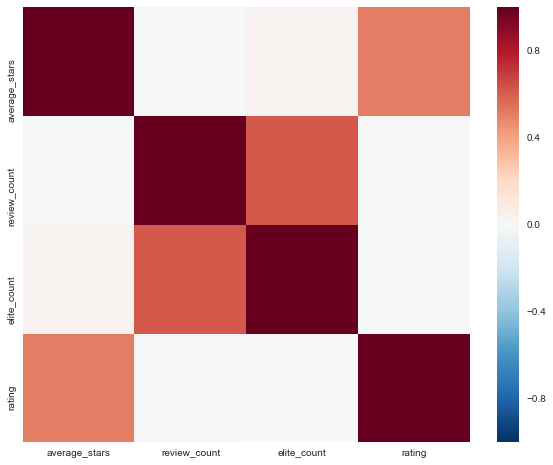

In [116]:
fig, ax = plt.subplots(1,1, figsize =(10,8))
sns.heatmap(user_review_viz.corr(), ax=ax)